# ESRGAN on WorldView-02 satellite imagery

https://arxiv.org/pdf/1809.00219.pdf

https://paperswithcode.com/paper/esrgan-enhanced-super-resolution-generative

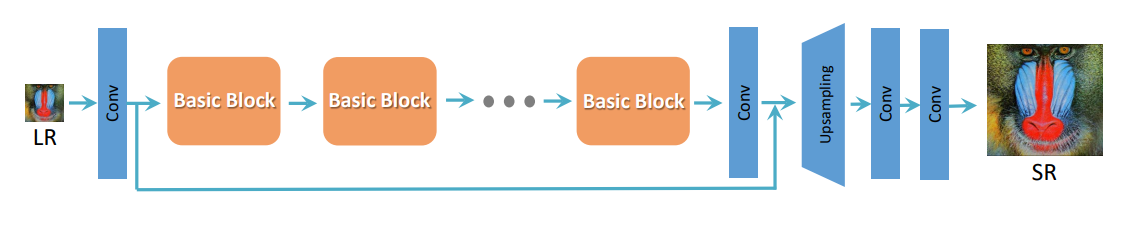

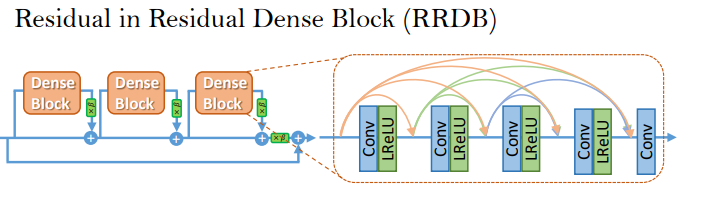

ESRGAN Won the PIRM 2018 SR challenge (for lowest perceptual index in region 3). This is an adaptation of ESRGAN to the multispectral (LR) to panchromatic (HR) mapping problem.

Key points about ESRGAN
- Improves on SRGAN from 2016 in several ways
 - Using RRDB (Residual in Residual Dense Blocks) design allowing for deeper models without vanishing gradient problem
 - Removing Batch Normalization layers, empirically shown to reduce artefacts
 - Relativistic GAN loss used for the discriminator
  - Predicts probability that a real image is relatively more realistic than a fake one and vice versa
  - Adversarial loss function thus include both real and fake/generated image (SRGAN only include generated)
 - Introduces interpolation between pretrained PSNR model and GAN model to tune trade-off between artefacts/smoothness
- Generator loss function components
 - Pixel loss in the form om L1 (Absolute Mean Error loss)
 - Adversarial loss from the discriminator
 - Content loss / Perceptual loss
  - Feature extraction from layer 54 of a VGG-19 model trained on ImageNet (before activation)
  
This implementation/adaptation
- Approx 17 million parameters
 - 8 bands/channels in (96x96)
 - 1 out (the panchromatic band) (384x384)
 - 4x upsampling
 - Satellite tiles sampled from satellite images
 - Georeference information preserved

# Imports and setup

In [ ]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
import rasterio
import rasterio.plot
import geopandas
import pickle
import functools
import datetime

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Path to location where individual satellite images are located
DATA_PATH = 'data/toulon-laspezia' 

# Paths to the tiled imagery
DATA_PATH_TILES = 'data/toulon-laspezia-tiles'
DATA_PATH_TILES_TRAIN = str(DATA_PATH_TILES + '/train')
DATA_PATH_TILES_VAL = str(DATA_PATH_TILES + '/val')
DATA_PATH_TILES_TEST = str(DATA_PATH_TILES + '/test')

# Loading the metadata geopandas df produced when generating tiles to disk
with open(str(DATA_PATH_TILES + '/metadata_tile_allocation.pickle'), 'rb') as file:
    meta = pickle.load(file)
    
N_IMAGES = len(meta.index)
N_IMAGES_TRAIN = meta['train_val_test'].value_counts()['train']
N_IMAGES_VAL = meta['train_val_test'].value_counts()['val']
N_IMAGES_TEST = meta['train_val_test'].value_counts()['test']
print('Number of satellite images - train:', N_IMAGES_TRAIN, 
      ', val:', N_IMAGES_VAL, ', test:', N_IMAGES_TEST)

N_TILES_TRAIN = meta.loc[meta['train_val_test'] == 'train', 'n_tiles'].sum()
N_TILES_VAL = meta.loc[meta['train_val_test'] == 'val', 'n_tiles'].sum()
N_TILES_TEST = meta.loc[meta['train_val_test'] == 'test', 'n_tiles'].sum()
print('Number of satellite image tiles - train:', N_TILES_TRAIN, 
      ', val:', N_TILES_VAL, ', test:', N_TILES_TEST)

PAN_WIDTH, PAN_HEIGHT = (384, 384)

SR_FACTOR = 4
MS_WIDTH, MS_HEIGHT = (int(PAN_WIDTH/SR_FACTOR), int(PAN_HEIGHT/SR_FACTOR))

# Should be derived automatically, but added here as a quick fix
PAN_BANDS = 1
MS_BANDS = 8

BATCH_SIZE = 1

WV02_BANDS = meta.loc[meta['sensorVehicle'] == 'WV02', ['ms_band0', 'ms_band1', 
                                                        'ms_band2', 'ms_band3', 
                                                        'ms_band4', 'ms_band5',
                                                        'ms_band6', 'ms_band7',]].iloc[0]

Number of satellite images - train: 22 , val: 10 , test: 10
Number of satellite image tiles - train: 10000 , val: 2000 , test: 2000


# Tensorflow tile generator from disk

Using `tf.data` API to construct a `Dataset` generator reading and preprocessing tiles from disk.

Best practices from https://www.tensorflow.org/guide/data, including multithreading, prefetching, shuffling, batching and caching.

`rasterio` is used to read geotiffs. the `decode_geotiff()` function is run inside a `tf.py_function()` wrapper ensuring that this function is also run in the computational graph.

In [ ]:
def decode_geotiff(image_path):
    image_path = pathlib.Path(image_path.numpy().decode())
    with rasterio.open(image_path) as src:
        img = src.read()
    img = rasterio.plot.reshape_as_image(img) # from channels first to channels last
    return img

def preprocess_images(img, ms_or_pan):
    if ms_or_pan == 'ms':
        h, w = MS_HEIGHT, MS_WIDTH
    elif ms_or_pan == 'pan':
        h, w = PAN_HEIGHT, PAN_WIDTH
        
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [h, w, -1]) # To avoid issue with extra dimension
    return img

def upsample_images(ms_img, pan_img):
    ms_img = tf.ensure_shape(ms_img, [MS_HEIGHT, MS_WIDTH, MS_BANDS])
    ms_img = tf.image.resize(ms_img, [PAN_HEIGHT, PAN_WIDTH])
    return ms_img, pan_img

def process_path(ms_tile_path):
    img_string_UID = tf.strings.split(ms_tile_path, os.sep)[-3]
    tile_UID = tf.strings.split(tf.strings.split(ms_tile_path, os.sep)[-1], '.')[0]
    
    ms_img = tf.py_function(decode_geotiff, [ms_tile_path], [tf.int16])
    pan_tile_path = tf.strings.regex_replace(ms_tile_path, '\\\\ms\\\\', '\\\\pan\\\\')
    pan_img = tf.py_function(decode_geotiff, [pan_tile_path], [tf.int16])
    
    ms_img = preprocess_images(ms_img, 'ms')
    pan_img = preprocess_images(pan_img, 'pan')
    
    return ms_img, pan_img

# https://www.tensorflow.org/tutorials/load_data/images
def prepare_for_training(ds, batch_size, cache=True, shuffle_buffer_size=100):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batch_size)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
def dataset_from_tif_tiles(tiles_path, batch_size, upsampling = False, 
                           cache = True, shuffle_buffer_size = 1000):
    
    ds = tf.data.Dataset.list_files(str(pathlib.Path(tiles_path)/'*/ms*.tif'))
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
    # upsampling through bicubic convolution before SR is required for SRCNN
    if upsampling:
        ds = ds.map(upsample_images, num_parallel_calls=AUTOTUNE)

    ds = prepare_for_training(ds, batch_size, cache, shuffle_buffer_size)
    return ds

ds_train = dataset_from_tif_tiles(DATA_PATH_TILES_TRAIN, BATCH_SIZE, 
                                  upsampling = False, shuffle_buffer_size = N_TILES_TRAIN)
ds_val = dataset_from_tif_tiles(DATA_PATH_TILES_VAL, BATCH_SIZE, 
                                upsampling = False, shuffle_buffer_size = N_TILES_VAL)
ds_test = dataset_from_tif_tiles(DATA_PATH_TILES_TEST, BATCH_SIZE, 
                                 upsampling = False, shuffle_buffer_size = N_TILES_TEST)

# Metrics and bicubic upsampling

Bicubic upsampling both as a function and a fixed (untrainable) Keras model.

In [ ]:
def psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=1.0)

def ssim(img1, img2):
    return tf.image.ssim(img1, img2, max_val=1.0)

def psnr_np(img1, img2):
    img1 = np.expand_dims(img1, -1)
    img2 = np.expand_dims(img2, -1)
    return tf.image.psnr(img1, img2, max_val=1.0)

def ssim_np(img1, img2):
    img1 = tf.convert_to_tensor(np.expand_dims(img1, -1), dtype = tf.float32)
    img2 = tf.convert_to_tensor(np.expand_dims(img2, -1), dtype = tf.float32)
    return tf.image.ssim(img1, img2, max_val=1.0)

def bicubic_upsample(imgs, upsample_factor):
    #print(imgs.shape)
    imgs = tf.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, [imgs.shape[1]*upsample_factor, imgs.shape[2]*upsample_factor], 
                           method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=False,
                           antialias=False, name=None)
    #print(imgs.shape)
    imgs = tf.squeeze(imgs)
    return imgs

def bicubic_model(size, upsample_factor, channels_in, channels_out):
    inputs = Input([size, size, channels_in], name='input_image')
    x = Lambda(lambda x:
               tf.expand_dims(tf.math.reduce_mean(x, axis = -1), axis = -1))(inputs)
    x = Lambda(lambda x: 
               tf.image.resize(x, [size*upsample_factor, size*upsample_factor], 
               method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=False,
               antialias=False, name=None))(x)
    return Model(inputs, x)

bicubic = bicubic_model(MS_HEIGHT, SR_FACTOR, MS_BANDS, PAN_BANDS)
bicubic.compile(loss='mean_absolute_error', metrics = [psnr, ssim])
bicubic.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 96, 96, 8)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 96, 96, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 384, 384, 1)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# Build the Residual-in-Residual Dense Block (RRDB) model

Code currently heavily based on https://github.com/peteryuX/esrgan-tf2

In [ ]:
def _regularizer(weights_decay=5e-4):
    return tf.keras.regularizers.l2(weights_decay)


def _kernel_init(scale=1.0, seed=None):
    """He normal initializer with scale."""
    scale = 2. * scale
    return tf.keras.initializers.VarianceScaling(
        scale=scale, mode='fan_in', distribution="truncated_normal", seed=seed)


class BatchNormalization(tf.keras.layers.BatchNormalization):
    """Make trainable=False freeze BN for real (the og version is sad).
       ref: https://github.com/zzh8829/yolov3-tf2
    """
    def __init__(self, axis=-1, momentum=0.9, epsilon=1e-5, center=True,
                 scale=True, name=None, **kwargs):
        super(BatchNormalization, self).__init__(
            axis=axis, momentum=momentum, epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs)

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)


class ResDenseBlock_5C(tf.keras.layers.Layer):
    """Residual Dense Block"""
    def __init__(self, nf=64, gc=32, res_beta=0.2, wd=0., name='RDB5C',
                 **kwargs):
        super(ResDenseBlock_5C, self).__init__(name=name, **kwargs)
        # gc: growth channel, i.e. intermediate channels
        self.res_beta = res_beta
        lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
        _Conv2DLayer = functools.partial(
            Conv2D, kernel_size=3, padding='same',
            kernel_initializer=_kernel_init(0.1), bias_initializer='zeros',
            kernel_regularizer=_regularizer(wd))
        self.conv1 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv2 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv3 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv4 = _Conv2DLayer(filters=gc, activation=lrelu_f())
        self.conv5 = _Conv2DLayer(filters=nf, activation=lrelu_f())

    def call(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(tf.concat([x, x1], 3))
        x3 = self.conv3(tf.concat([x, x1, x2], 3))
        x4 = self.conv4(tf.concat([x, x1, x2, x3], 3))
        x5 = self.conv5(tf.concat([x, x1, x2, x3, x4], 3))
        return x5 * self.res_beta + x


class ResInResDenseBlock(tf.keras.layers.Layer):
    """Residual in Residual Dense Block"""
    def __init__(self, nf=64, gc=32, res_beta=0.2, wd=0., name='RRDB',
                 **kwargs):
        super(ResInResDenseBlock, self).__init__(name=name, **kwargs)
        self.res_beta = res_beta
        self.rdb_1 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_2 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)
        self.rdb_3 = ResDenseBlock_5C(nf, gc, res_beta=res_beta, wd=wd)

    def call(self, x):
        out = self.rdb_1(x)
        out = self.rdb_2(out)
        out = self.rdb_3(out)
        return out * self.res_beta + x


def RRDB_Model(size, channels_in, channels_out, cfg_net, gc=32, wd=0., name='RRDB_model'):
    """Residual-in-Residual Dense Block based Model """
    nf, nb = cfg_net['nf'], cfg_net['nb']
    lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
    rrdb_f = functools.partial(ResInResDenseBlock, nf=nf, gc=gc, wd=wd)
    conv_f = functools.partial(Conv2D, kernel_size=3, padding='same',
                               bias_initializer='zeros',
                               kernel_initializer=_kernel_init(),
                               kernel_regularizer=_regularizer(wd))
    rrdb_truck_f = tf.keras.Sequential(
        [rrdb_f(name="RRDB_{}".format(i)) for i in range(nb)],
        name='RRDB_trunk')

    # extraction
    x = inputs = Input([size, size, channels_in], name='input_image')
    fea = conv_f(filters=nf, name='conv_first')(x)
    fea_rrdb = rrdb_truck_f(fea)
    trunck = conv_f(filters=nf, name='conv_trunk')(fea_rrdb)
    fea = fea + trunck

    # upsampling
    size_fea_h = tf.shape(fea)[1] if size is None else size
    size_fea_w = tf.shape(fea)[2] if size is None else size
    fea_resize = tf.image.resize(fea, [size_fea_h * 2, size_fea_w * 2],
                                 method='nearest', name='upsample_nn_1')
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_1')(fea_resize)
    fea_resize = tf.image.resize(fea, [size_fea_h * 4, size_fea_w * 4],
                                 method='nearest', name='upsample_nn_2')
    fea = conv_f(filters=nf, activation=lrelu_f(), name='upconv_2')(fea_resize)
    fea = conv_f(filters=nf, activation=lrelu_f(), name='conv_hr')(fea)
    out = conv_f(filters=channels_out, name='conv_last')(fea)

    return Model(inputs, out, name=name)

In [ ]:
def build_rrdb_model(optimizer = Adam(lr=0.000010), loss = 'mean_absolute_error', 
                     n_filters = 64, n_blocks = 23, metrics = [psnr, ssim]):
    
    cfg_net = {'nf': n_filters, 'nb': n_blocks}
    rrdb = RRDB_Model(MS_HEIGHT, MS_BANDS, 1, cfg_net)
    rrdb.compile(optimizer=optimizer, loss=loss, metrics = metrics)
    return rrdb

pretrain_model =  build_rrdb_model(optimizer = Adam(lr=0.000010), loss = 'mean_absolute_error', 
                                   n_filters = 64, n_blocks = 23, metrics = [psnr, ssim])
pretrain_model.summary()

Model: "RRDB_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 96, 96, 8)]  0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 96, 96, 64)   4672        input_image[0][0]                
__________________________________________________________________________________________________
RRDB_trunk (Sequential)         (None, 96, 96, 64)   16546752    conv_first[0][0]                 
__________________________________________________________________________________________________
conv_trunk (Conv2D)             (None, 96, 96, 64)   36928       RRDB_trunk[0][0]                 
_________________________________________________________________________________________

# Pretraining the model with PSNR loss

This is done in the ESRGAN paper and the rationale behind is that you want a reasonable starting point for your GAN training later.

In [ ]:
log_dir = pathlib.Path('logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'models/esrgan-sat-m1-2-{epoch:02d}-{val_loss:.6f}.h5', 
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = True,
    )

In [ ]:
pretrain_model.load_weights('models/esrgan-psnr-final.h5')

In [ ]:
#pretrain_model.save_weights("models/esrgan-psnr-final.h5")

# Visual inspection after pretraining

First we need some helper functions related to pansharpening and rgb coding of multispectral (ms) images.

In [ ]:
def stretch(image, individual_bands = True):
    image_out = np.empty(image.shape)
    if individual_bands:
        for i in range(image.shape[2]):
            image_out[:,:,i] = (image[:,:,i] - np.min(image[:,:,i])) / (np.max(image[:,:,i]) - np.min(image[:,:,i]))
    else:
        image_out = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image_out

def pansharpen(ms, pan, sensor = 'WV02', method = 'brovey', fourth_band = 'nir', 
               w = [0.2]*5, stretch_output = True):
    ms = ms[:,:,:]
    pan = pan[:,:]
    
    scale = int(pan.shape[0]/ms.shape[0])

    ms_ups = tf.image.resize(ms, [ms.shape[0]*scale, ms.shape[1]*scale], 
                         method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=False,
                         antialias=False, name=None)

    # Convert to ndarray if tensor
    if isinstance(pan, tf.python.framework.ops.EagerTensor):
        pan = pan.numpy()
    if isinstance(ms_ups, tf.python.framework.ops.EagerTensor):
        ms_ups = ms_ups.numpy()
    
    if sensor == 'WV02':
        r = ms_ups[:,:,4]
        g = ms_ups[:,:,2]
        b = ms_ups[:,:,1]
        if fourth_band == 'red_edge':
            i = ms_ups[:,:,5]
        elif fourth_band == 'nir':
            i = ms_ups[:,:,6]
        elif fourth_band == 'nir2':
            i = ms_ups[:,:,7]
        
    if method == 'brovey':
        dnf = (pan - w[3]*i)/(w[0]*r + w[1]*g + w[2]*b)
        r = np.expand_dims(r * dnf, -1)
        g = np.expand_dims(g * dnf, -1)
        b = np.expand_dims(b * dnf, -1)
        i = np.expand_dims(i * dnf, -1)
        img_out = np.concatenate([r, g, b], axis = 2)
        #print(img_out.shape)
    
    if stretch_output:
        img_out = stretch(img_out)
        
    return img_out

def ms_to_rgb(ms, sensor = 'WV02'):
    if sensor == 'WV02':
        rgb = [np.expand_dims(ms[:,:,4], -1), 
               np.expand_dims(ms[:,:,2], -1), 
               np.expand_dims(ms[:,:,1], -1)]
    elif sensor == 'GE01':
        rgb = [np.expand_dims(ms[:,:,2], -1), 
               np.expand_dims(ms[:,:,1], -1), 
               np.expand_dims(ms[:,:,0], -1)]
    elif sensor == 'WV03_VNIR':
        rgb = [np.expand_dims(ms[:,:,1], -1), 
               np.expand_dims(ms[:,:,2], -1), 
               np.expand_dims(ms[:,:,3], -1)]
    else:
        raise ValueError('Only WV02, GE01 and WV03_VNIR band configurations implemented') 
    
    rgb = np.concatenate(rgb, axis = 2)
    rgb = stretch(rgb)
    return rgb

## Plot functions

Some effort put into creating an adaptable comparison plot function.

In [ ]:
def plot_subplot(ax, img, title, gray = False, metrics = False):
    ax.set_title(title)
    if gray:
        ax.imshow(img, cmap = 'gray')
    else:
        ax.imshow(img)
        
    # TODO: Implement metrics in title
    #axs[0,1].set_title('MS Bicubic Upsampling ' + 
    #                   '\n PSNR: ' + 
    #                   str(psnr_np(bicubic[i], pan[i]).numpy()) + 
    #                   '\n SSIM: ' +
    #                   str(ssim_np(bicubic[i], pan[i]).numpy()))
    #axs[0,1].imshow(bicubic[i], cmap = cmap)
    return ax
    
def plot_comparison(ds, pretrain_model = False, gan_model = False, bicubic = True, 
                    rgb = True, pansharp = False, sensor = 'WV02', save_path = False):
    imgs, plot, gray, metrics = {}, {}, {}, {}
    batch = next(iter(ds)) # Batch size = 1
    
    imgs['ms'] = batch[0][0].numpy()
    imgs['ms_mean'] = tf.math.reduce_mean(imgs['ms'], axis = -1).numpy()
    plot['ms_mean'], gray['ms_mean'] = True, True
    
    if rgb:
        imgs['ms_rgb'] = ms_to_rgb(imgs['ms'], sensor = 'WV02')
        plot['ms_rgb'], gray['ms_rgb'] = True, False
    
    if bicubic:
        imgs['bicubic'] = tf.image.resize(imgs['ms'], 
                                          [imgs['ms'].shape[0]*SR_FACTOR, imgs['ms'].shape[1]*SR_FACTOR], 
                                          method=tf.image.ResizeMethod.BICUBIC).numpy()

        imgs['bicubic_mean'] = tf.math.reduce_mean(imgs['bicubic'], axis = -1).numpy()
        plot['bicubic_mean'], gray['bicubic_mean'] = True, True
        if rgb:
            imgs['bicubic_rgb'] = ms_to_rgb(imgs['bicubic'], sensor = 'WV02')
            plot['bicubic_rgb'], gray['bicubic_rgb'] = True, False
    
    if not isinstance(pretrain_model, bool):
        imgs['sr_pretrain'] = pretrain_model.predict(batch)[0,:,:,0]
        plot['sr_pretrain'], gray['sr_pretrain'] = True, True
        
    if not isinstance(gan_model, bool):
        imgs['sr_gan'] = gan_model.predict(batch)[0,:,:,0]
        plot['sr_gan'] = True
        gray['sr_gan'] = True
        
    imgs['pan'] = batch[1].numpy()[0,:,:,0]
    plot['pan'], gray['pan'] = True, True
    
    if pansharp:
        if not isinstance(pretrain_model, bool):
            imgs['sr_pretrain_pansharp'] = pansharpen(imgs['ms'], imgs['sr_pretrain'], sensor = 'WV02', 
                                                      method = 'brovey', fourth_band = 'nir', 
                                                      w = [0.2]*5, stretch_output = True)
            plot['sr_pretrain_pansharp'], gray['sr_pretrain_pansharp'] = True, False

        if not isinstance(gan_model, bool):
            imgs['sr_gan_pansharp'] = pansharpen(imgs['ms'], imgs['sr_gan'], sensor = 'WV02', 
                                                      method = 'brovey', fourth_band = 'nir', 
                                                      w = [0.2]*5, stretch_output = True)
            plot['sr_gan_pansharp'], gray['sr_gan_pansharp'] = True, False

        imgs['real_pansharp'] = pansharpen(imgs['ms'], imgs['pan'], sensor = 'WV02', 
                                                  method = 'brovey', fourth_band = 'nir', 
                                                  w = [0.2]*5, stretch_output = True)
        plot['real_pansharp'], gray['real_pansharp'] = True, False
    
    n_subplots = sum(plot.values())
    print('Plotting', n_subplots, 'subplots')
    for img_name in plot.keys():
        print(img_name, imgs[img_name].shape)
    n_cols = 3
    n_rows = math.ceil(n_subplots/n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, constrained_layout = True, 
                            figsize = (n_cols*10, n_rows*10))
    fig.suptitle('Satellite image tiles - Comparisons between multispectral, panchromatic and super-resolution images')
    fig.patch.set_facecolor('white')
    subplot_keys = list(plot.keys())
    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            img_name = subplot_keys[k]
            plot_subplot(axs[i,j], imgs[img_name], img_name, gray[img_name])
            k += 1
            if k >= len(subplot_keys):
                break
                
    if not isinstance(save_path, bool):
        fig.savefig(save_path)

Plotting 8 subplots
ms_mean (96, 96)
ms_rgb (96, 96, 3)
bicubic_mean (384, 384)
bicubic_rgb (384, 384, 3)
sr_pretrain (384, 384)
pan (384, 384)
sr_pretrain_pansharp (384, 384, 3)
real_pansharp (384, 384, 3)


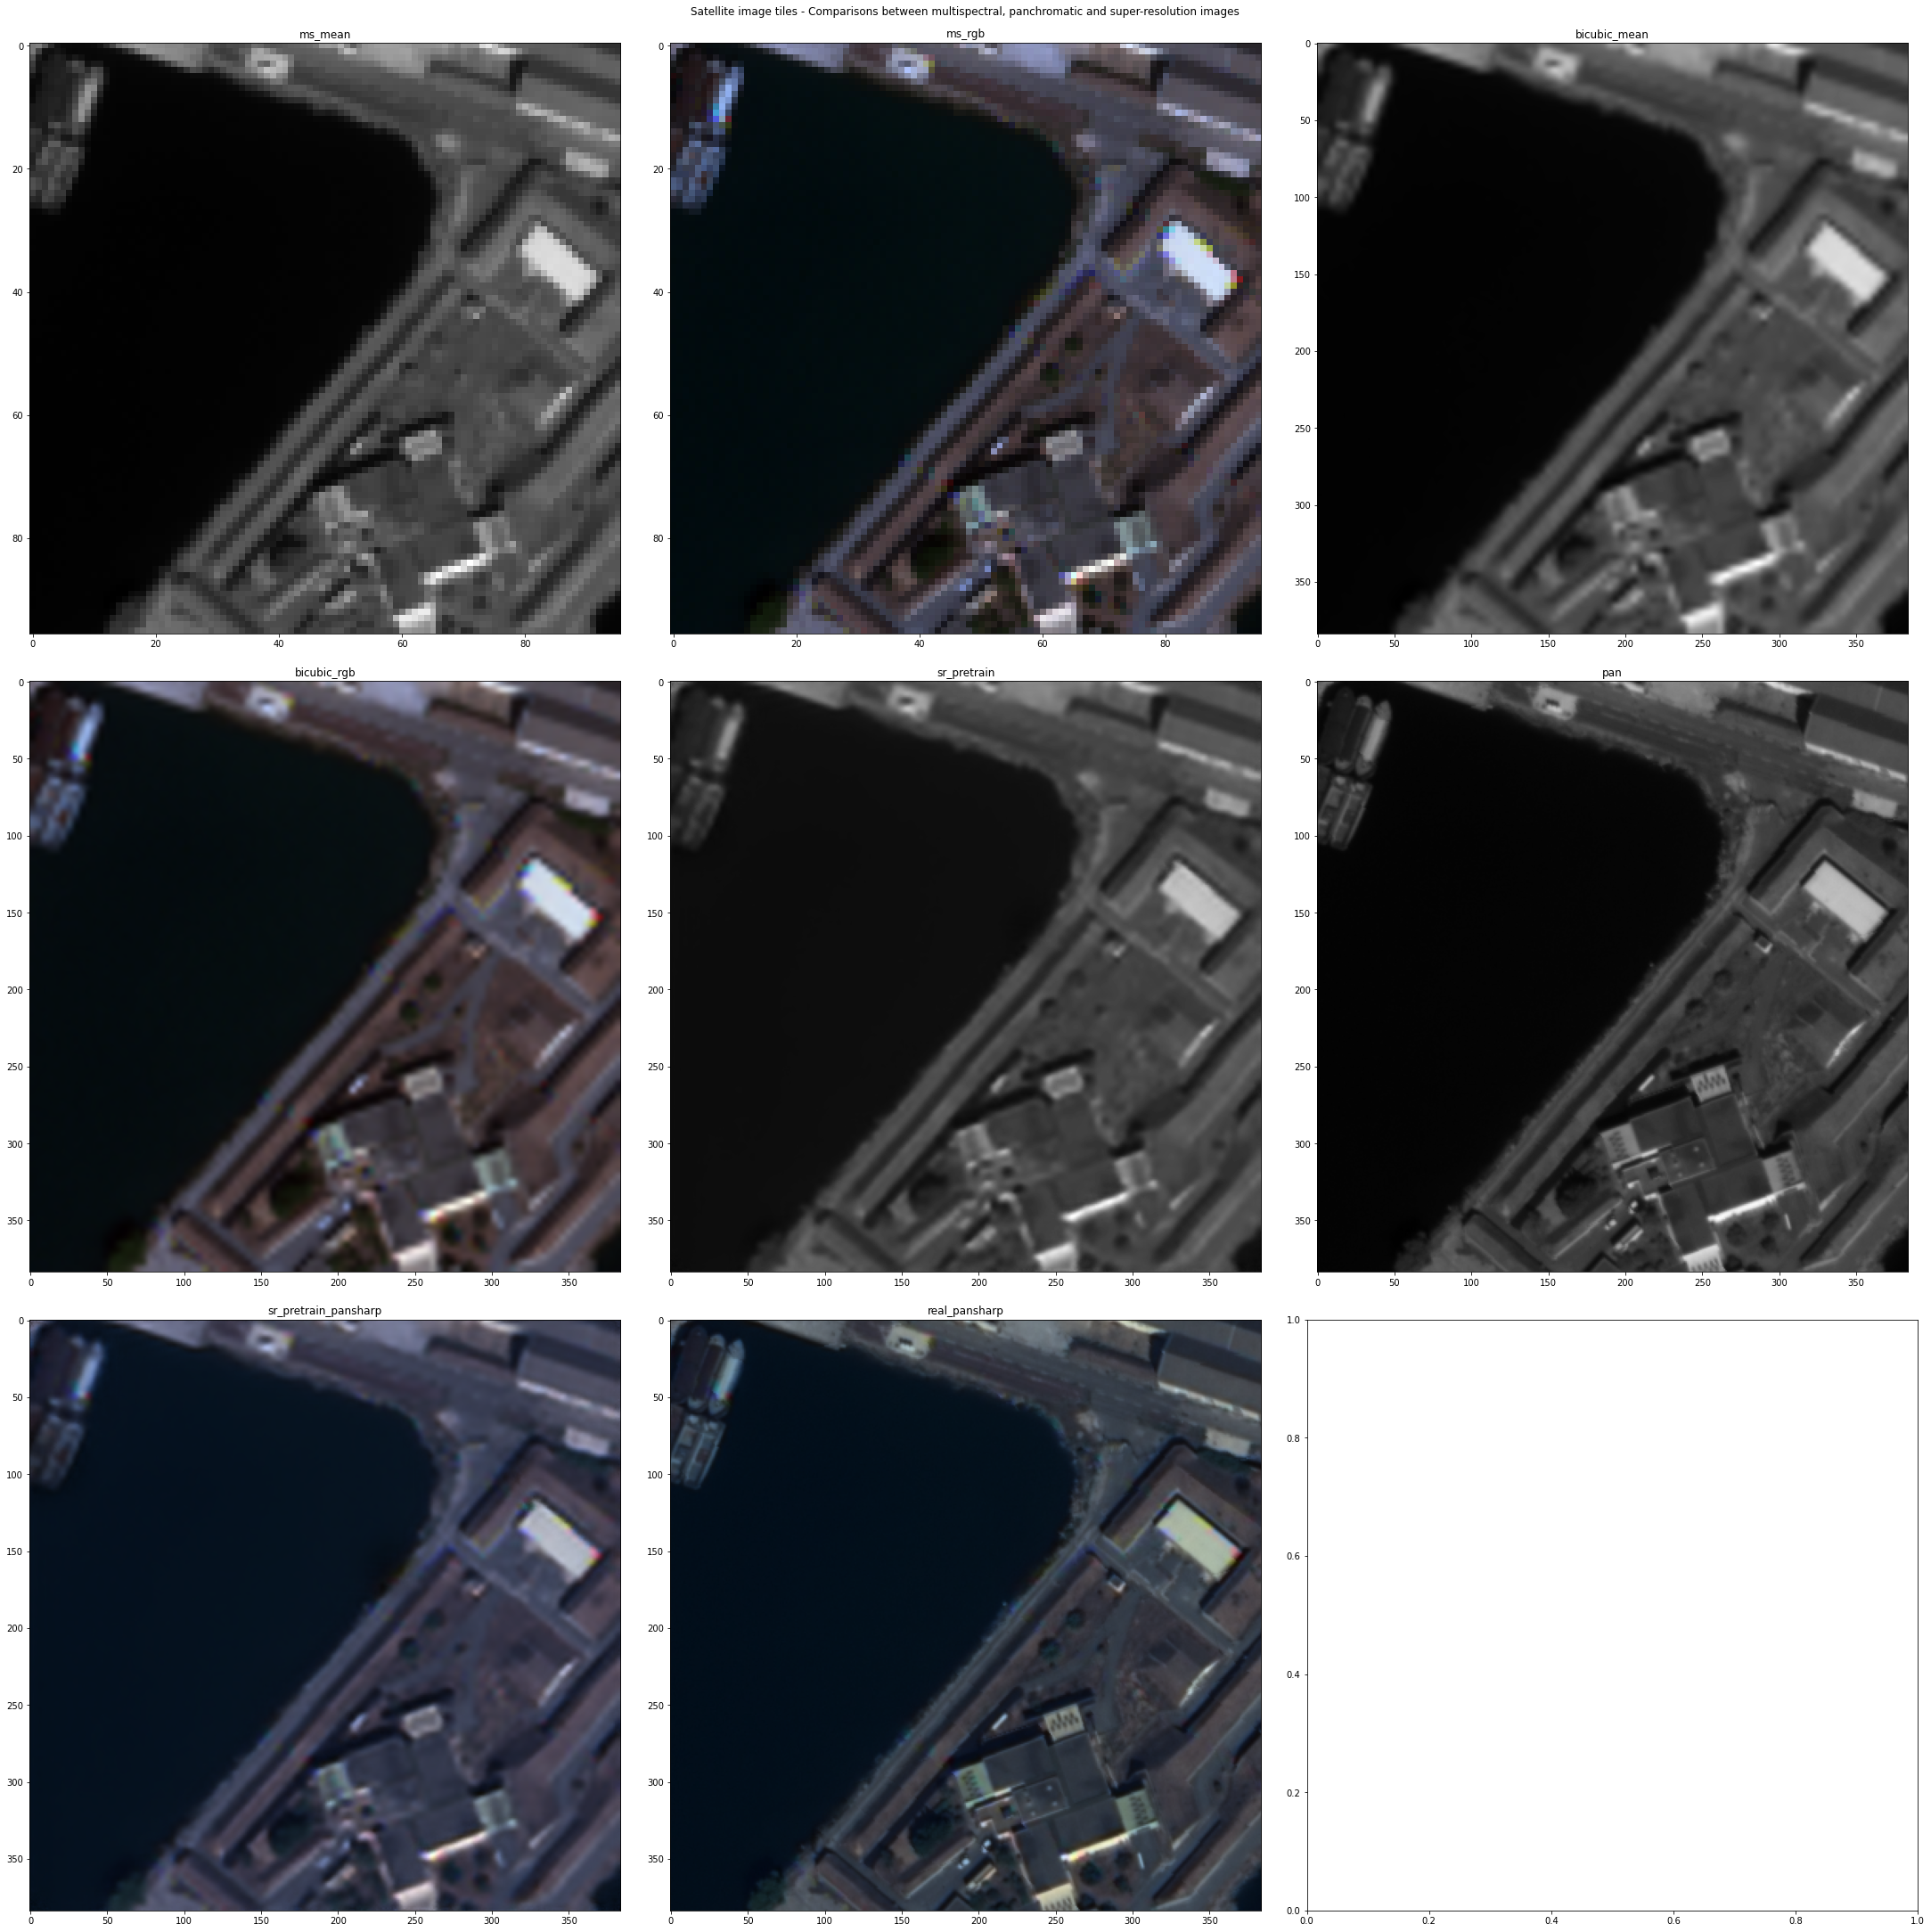

In [ ]:
plot_comparison(ds_val, pretrain_model, gan_model = False, rgb = True, pansharp = True, sensor = 'WV02')

## Evaluaton on validation set

Takes a couple of minutes.

In [ ]:
#bicubic.evaluate(ds_val, steps = 1000)
#pretrain_model.evaluate(ds_val, steps = 1000)

# GAN training

Code currently heavily based on https://github.com/peteryuX/esrgan-tf2. Lacks a lot when it comes to Tensorboard monitoring.

Currently uses perceptual loss of an intermediate layer in a VGG19 model trained on ImageNet. This is probably suboptimal for the satellite imagery domain. Considering using a BigEarthNet VGG19 model instead http://bigearth.net/.

## Loss functions

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

# Small hack. TODO: Should maybe create a class of the whole thing
vgg = VGG19(input_shape=(None, None, 3), include_top=False) #By default loads ImageNet weights
fea_extrator = tf.keras.Model(vgg.input, vgg.layers[20].output)

def PixelLoss(criterion='l1'):
    """pixel loss"""
    if criterion == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        return tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))


def ContentLoss(criterion='l1', output_layer=54, before_act=True):
    """content loss"""
    if criterion == 'l1':
        loss_func = tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        loss_func = tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))
    #vgg = VGG19(input_shape=(None, None, 3), include_top=False)

    if output_layer == 22:  # Low level feature
        pick_layer = 5
    elif output_layer == 54:  # Hight level feature
        pick_layer = 20
    else:
        raise NotImplementedError(
            'VGG output layer {} is not recognized.'.format(criterion))

    if before_act:
        vgg.layers[pick_layer].activation = None

    #fea_extrator = tf.keras.Model(vgg.input, vgg.layers[pick_layer].output)

    @tf.function
    def content_loss(hr, sr):
        print(sr.shape, hr.shape)
        sr_rgb = tf.image.grayscale_to_rgb(sr)
        hr_rgb = tf.image.grayscale_to_rgb(hr)
        print(sr_rgb.shape, hr_rgb.shape)
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_sr = preprocess_input(sr_rgb * 255.) / 12.75
        preprocess_hr = preprocess_input(hr_rgb * 255.) / 12.75
        print(preprocess_sr.shape, preprocess_hr.shape)
        sr_features = fea_extrator(preprocess_sr)
        hr_features = fea_extrator(preprocess_hr)

        return loss_func(hr_features, sr_features)

    return content_loss


def DiscriminatorLoss(gan_type='ragan'):
    """discriminator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def discriminator_loss_ragan(hr, sr):
        return 0.5 * (
            cross_entropy(tf.ones_like(hr), sigma(hr - tf.reduce_mean(sr))) +
            cross_entropy(tf.zeros_like(sr), sigma(sr - tf.reduce_mean(hr))))

    def discriminator_loss(hr, sr):
        real_loss = cross_entropy(tf.ones_like(hr), sigma(hr))
        fake_loss = cross_entropy(tf.zeros_like(sr), sigma(sr))
        return real_loss + fake_loss

    if gan_type == 'ragan':
        return discriminator_loss_ragan
    elif gan_type == 'gan':
        return discriminator_loss
    else:
        raise NotImplementedError(
            'Discriminator loss type {} is not recognized.'.format(gan_type))


def GeneratorLoss(gan_type='ragan'):
    """generator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def generator_loss_ragan(hr, sr):
        return 0.5 * (
            cross_entropy(tf.ones_like(sr), sigma(sr - tf.reduce_mean(hr))) +
            cross_entropy(tf.zeros_like(hr), sigma(hr - tf.reduce_mean(sr))))

    def generator_loss(hr, sr):
        return cross_entropy(tf.ones_like(sr), sigma(sr))

    if gan_type == 'ragan':
        return generator_loss_ragan
    elif gan_type == 'gan':
        return generator_loss
    else:
        raise NotImplementedError(
            'Generator loss type {} is not recognized.'.format(gan_type))

## The Discriminator model

In [ ]:
def DiscriminatorVGG(size, channels, nf=64, wd=0.,
                     name='Discriminator_VGG'):
    """Discriminator VGG"""
    lrelu_f = functools.partial(LeakyReLU, alpha=0.2)
    conv_k3s1_f = functools.partial(Conv2D,
                                    kernel_size=3, strides=1, padding='same',
                                    kernel_initializer=_kernel_init(),
                                    kernel_regularizer=_regularizer(wd))
    conv_k4s2_f = functools.partial(Conv2D,
                                    kernel_size=4, strides=2, padding='same',
                                    kernel_initializer=_kernel_init(),
                                    kernel_regularizer=_regularizer(wd))
    dese_f = functools.partial(Dense, kernel_regularizer=_regularizer(wd))

    x = inputs = Input(shape=(size, size, channels))

    x = conv_k3s1_f(filters=nf, name='conv0_0')(x)
    x = conv_k4s2_f(filters=nf, use_bias=False, name='conv0_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn0_1')(x))

    x = conv_k3s1_f(filters=nf * 2, use_bias=False, name='conv1_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn1_0')(x))
    x = conv_k4s2_f(filters=nf * 2, use_bias=False, name='conv1_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn1_1')(x))

    x = conv_k3s1_f(filters=nf * 4, use_bias=False, name='conv2_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn2_0')(x))
    x = conv_k4s2_f(filters=nf * 4, use_bias=False, name='conv2_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn2_1')(x))

    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv3_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn3_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv3_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn3_1')(x))

    x = conv_k3s1_f(filters=nf * 8, use_bias=False, name='conv4_0')(x)
    x = lrelu_f()(BatchNormalization(name='bn4_0')(x))
    x = conv_k4s2_f(filters=nf * 8, use_bias=False, name='conv4_1')(x)
    x = lrelu_f()(BatchNormalization(name='bn4_1')(x))

    x = Flatten()(x)
    x = dese_f(units=100, activation=lrelu_f(), name='linear1')(x)
    out = dese_f(units=1, name='linear2')(x)

    return Model(inputs, out, name=name)

# Actual GAN training

In [ ]:
gan_model =  build_rrdb_model(n_filters = 64, n_blocks = 23, metrics = [psnr, ssim])
#gan_model.summary()

# Loading pre-trained weights from pretrain_model
gan_model.load_weights('models/esrgan-psnr-final.h5')

In [ ]:
def train_esrgan(psnr_model, dataset, steps, learning_rate_G, learning_rate_D):
    # define network
    generator = psnr_model
    #generator.summary(line_length=80)
    discriminator = DiscriminatorVGG(PAN_HEIGHT, PAN_BANDS)
    #discriminator.summary(line_length=80)


    # define optimizer
    #learning_rate_G = MultiStepLR(cfg['lr_G'], cfg['lr_steps'], cfg['lr_rate'])
    #learning_rate_D = MultiStepLR(cfg['lr_D'], cfg['lr_steps'], cfg['lr_rate'])
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=learning_rate_G)
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=learning_rate_D)

    # define losses function
    pixel_loss_fn = PixelLoss(criterion='l1')
    fea_loss_fn = ContentLoss(criterion='l1')
    gen_loss_fn = GeneratorLoss(gan_type='ragan')
    dis_loss_fn = DiscriminatorLoss(gan_type='ragan')
    
    # define training step function
    @tf.function
    def train_step(lr, hr):
        with tf.GradientTape(persistent=True) as tape:
            sr = generator(lr, training=True)
            hr_output = discriminator(hr, training=True)
            sr_output = discriminator(sr, training=True)

            losses_G = {}
            losses_D = {}
            losses_G['reg'] = tf.reduce_sum(generator.losses)
            losses_D['reg'] = tf.reduce_sum(discriminator.losses)
            losses_G['pixel'] = 0.01 * pixel_loss_fn(hr, sr)
            losses_G['feature'] = 1.0 * fea_loss_fn(hr, sr)
            losses_G['gan'] = 0.005 * gen_loss_fn(hr_output, sr_output)
            losses_D['gan'] = dis_loss_fn(hr_output, sr_output)
            total_loss_G = tf.add_n([l for l in losses_G.values()])
            total_loss_D = tf.add_n([l for l in losses_D.values()])

        grads_G = tape.gradient(
            total_loss_G, generator.trainable_variables)
        grads_D = tape.gradient(
            total_loss_D, discriminator.trainable_variables)
        optimizer_G.apply_gradients(
            zip(grads_G, generator.trainable_variables))
        optimizer_D.apply_gradients(
            zip(grads_D, discriminator.trainable_variables))

        return total_loss_G, total_loss_D, losses_G, losses_D


    i = 0
    for lr, hr in dataset.take(steps):
        total_loss_G, total_loss_D, losses_G, losses_D = train_step(lr, hr)
        
        if i % 10 == 0:
            print(i, total_loss_G, total_loss_D)

        i += 1
        
    print("\n [*] training done!")
    
#train_esrgan(gan_model, ds_train, 20000, 0.0001, 0.0001)

In [ ]:
#gan_model.save_weights("models/esrgan-gan-final.h5")

In [ ]:
#gan_model.load_weights("models/esrgan-gan-final.h5")
gan_model.load_weights("models/esrgan-gan-final2-lr-halving3.h5")

# Evaluation after GAN training

Plotting 10 subplots
ms_mean (96, 96)
ms_rgb (96, 96, 3)
bicubic_mean (384, 384)
bicubic_rgb (384, 384, 3)
sr_pretrain (384, 384)
sr_gan (384, 384)
pan (384, 384)
sr_pretrain_pansharp (384, 384, 3)
sr_gan_pansharp (384, 384, 3)
real_pansharp (384, 384, 3)


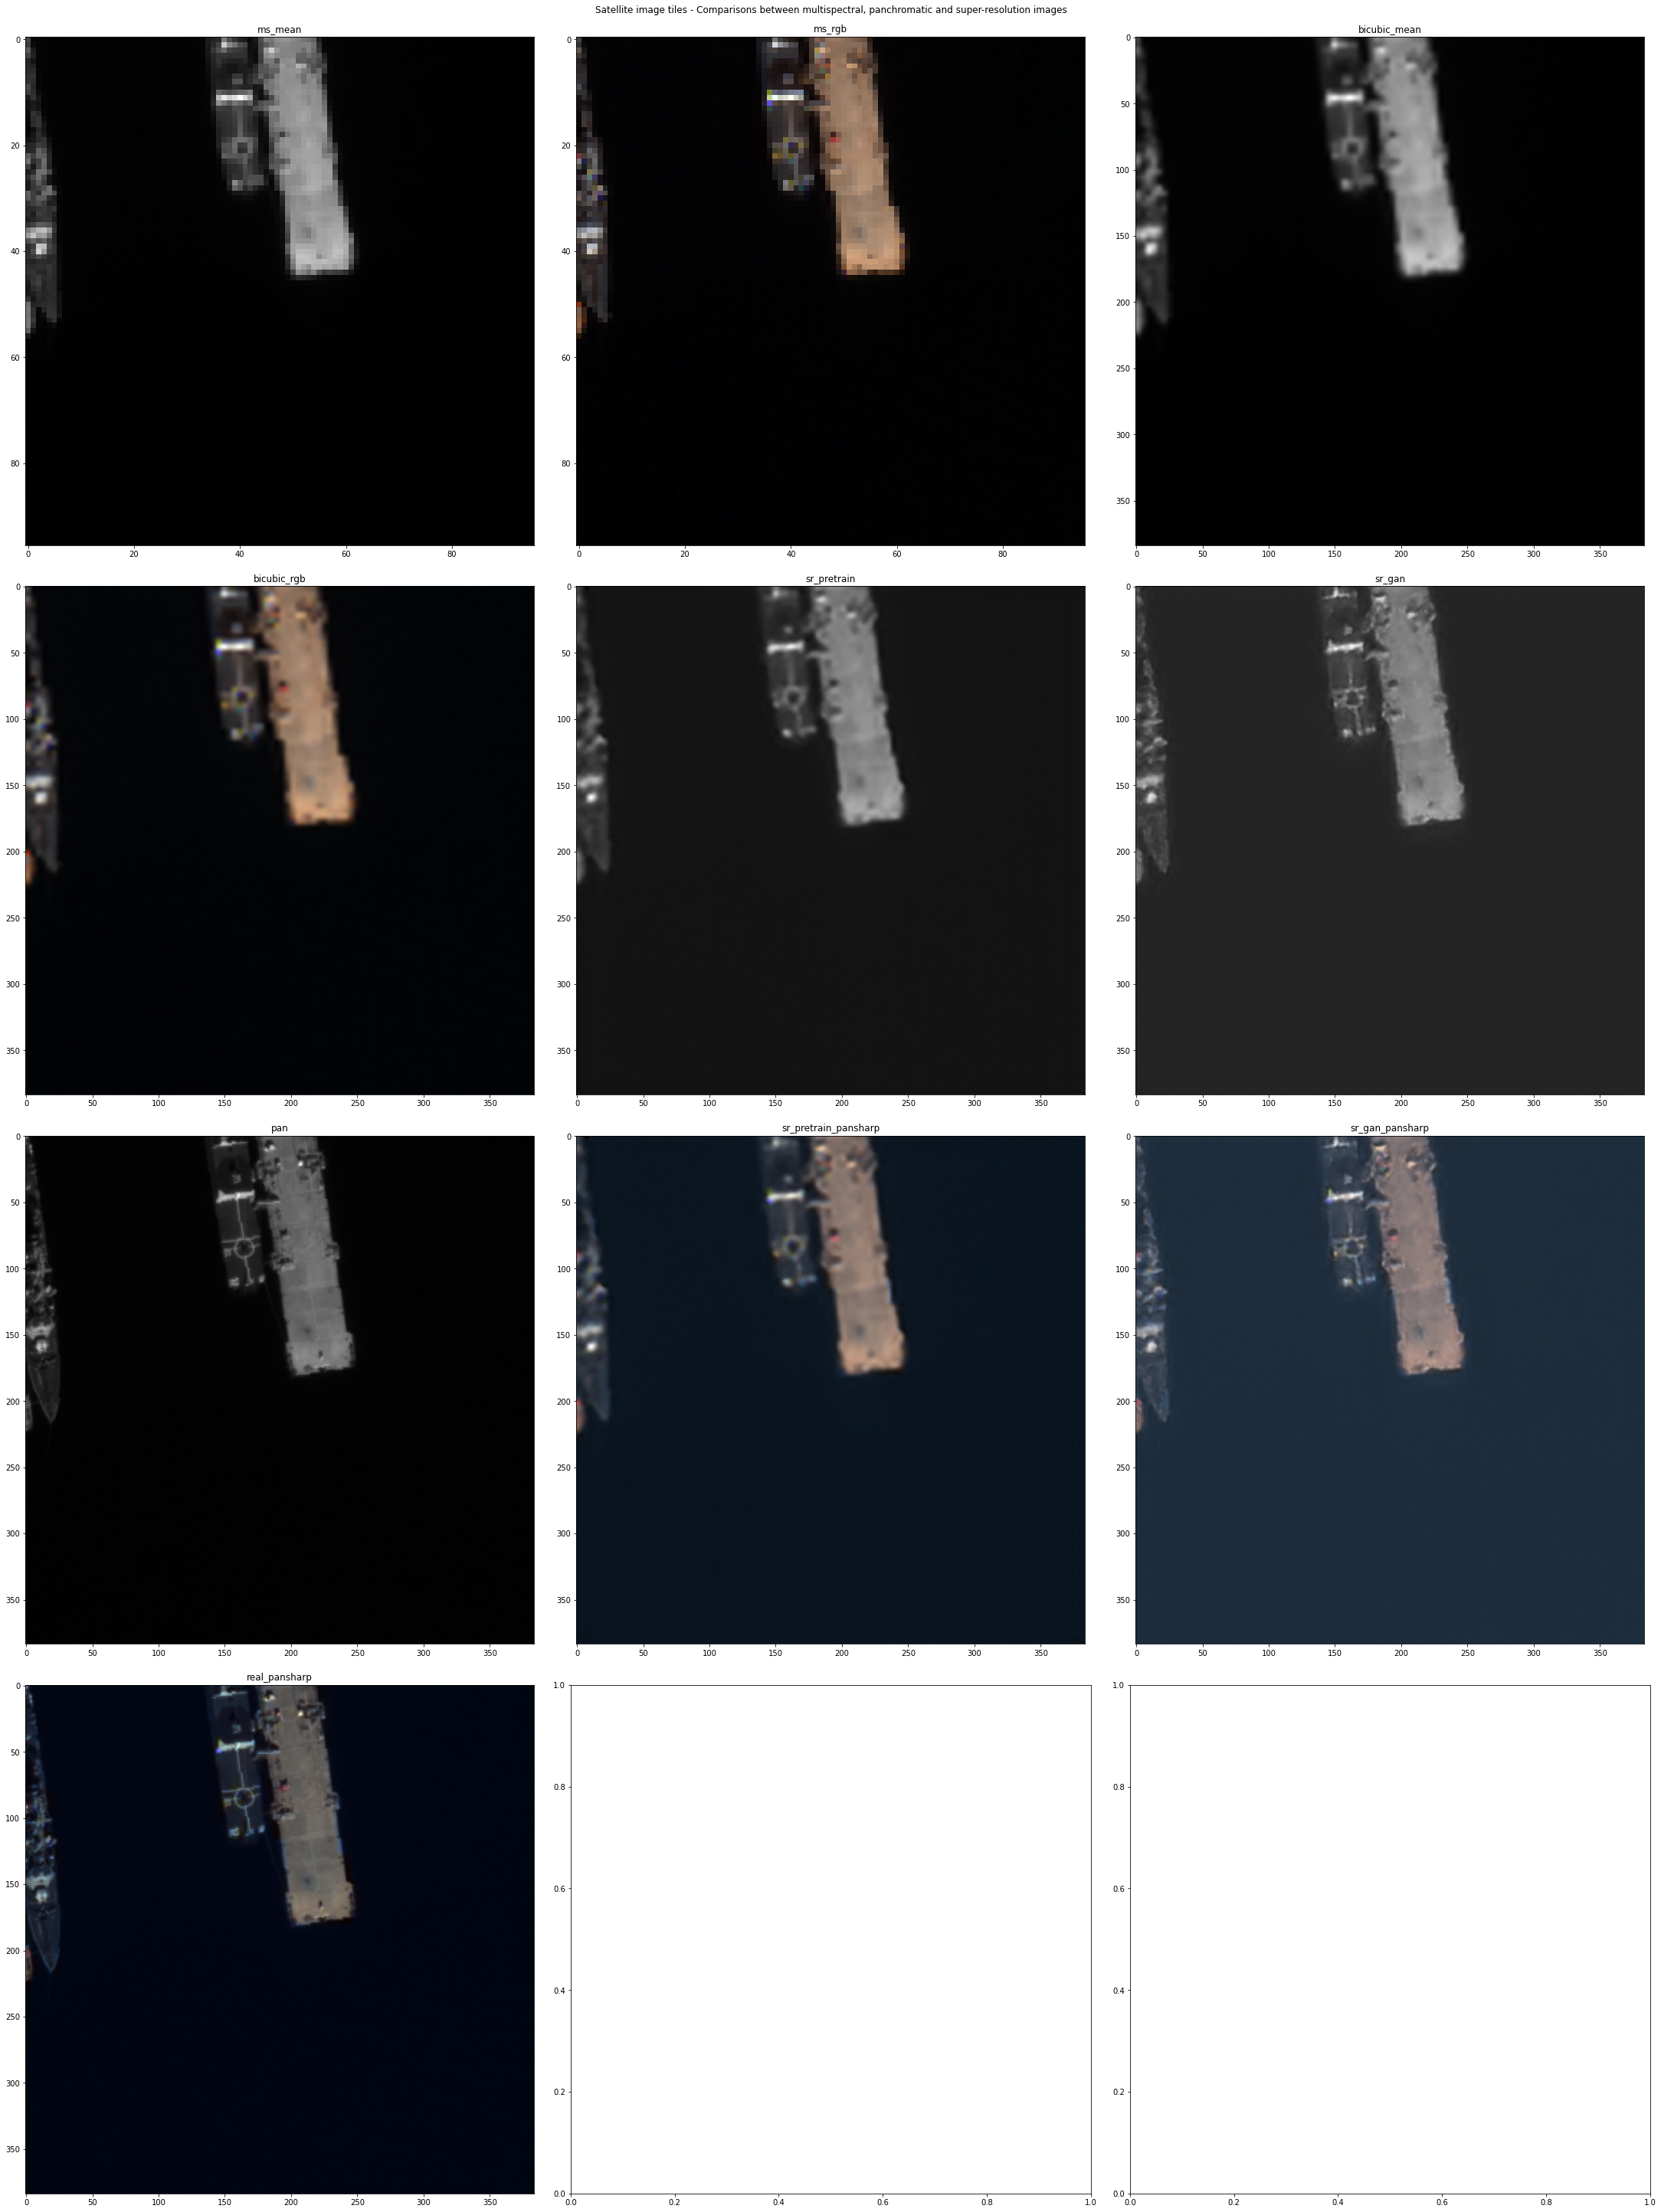

In [ ]:
plot_comparison(ds_val, pretrain_model, gan_model = gan_model, rgb = True, pansharp = True, sensor = 'WV02', 
                save_path = False)

# Save a bunch of comparison plots to disk

In [ ]:
#for i in range(50):
#    plot_comparison(ds_val, pretrain_model, gan_model = gan_model, rgb = True, pansharp = True, sensor = 'WV02', 
#                save_path = str('results/comparison-plots/2020-10-07-pretrain-and-gan-' + str(i).zfill(3)))